<a href="https://colab.research.google.com/github/Lexaun-chen/Image-Deblurring-Numerical-Optimization/blob/main/notebooks/1_preprocessing_and_blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Deblurring and QR Factorizations

## Part One： Preprocessing & Blurring

The first part of the Notebook should include the following components:

  1.	Loading Data – Read the input image and convert it to grayscale.

  2.	Constructing the Blurring Kernel – Define and generate a motion blur kernel.

  3.	Applying the Blurring Process – Convolve the image with the blur kernel to simulate motion blur.

  4.	Saving the Blurred Image – Store the processed image for use in the next stage of deblurring.

In [ ]:
import os
import time
from PIL import Image

import numpy as np
from numpy import asarray
from matplotlib import image
import matplotlib.pyplot as plt

import scipy.linalg
from scipy import linalg
from scipy.linalg import solve
from scipy.sparse import linalg as splinalg
import matplotlib.pyplot as plt

In [1]:
"""
part(a)

    Load image
    Construct blurring kernels
    Derive blurring images

    When processing the problem, we find the shape of images in tested_images are not unified. For example, '1250_m3_original.png' has channel parameter, but '1024_books_original.png' not. To make the structure of the code clearer, we uniformly converted the images to single-channel grayscale images when loading and saving them.
"""

"\npart(a)\n\n    Load image\n    Construct blurring kernels\n    Derive blurring images\n\n    When processing the problem, we find the shape of images in tested_images are not unified. For example, '1250_m3_original.png' has channel parameter, but '1024_books_original.png' not. To make the structure of the code clearer, we uniformly converted the images to single-channel grayscale images when loading and saving them.\n"

In [ ]:
def load_image(path):
    """Load image and convert to grayscale, normalize to [0,1] range"""
    # Load image and convert to grayscale
    img = Image.open(path).convert('L')

    # Convert to numpy array and normalize to [0,1]
    img_array = np.array(img).astype(np.float64) / 255.0

    return img_array

def save_image(img, path):
    """Save normalized grayscale image"""
    # Ensure the image is in [0,1] range
    img_normalized = np.clip(img, 0, 1)
    # Convert to uint8 [0,255] range
    img_uint8 = (img_normalized * 255).astype(np.uint8)
    # Save using PIL
    Image.fromarray(img_uint8, mode='L').save(path)

In [ ]:
def build_blur_kernel(n, j, k, upper_triangular=True, extra_subdiagonal=False):
    A = np.zeros((n, n))
    weights = np.array([k - i for i in range(k)])
    weights = (2 / (k * (k + 1))) * weights  # Normalize weights

    for i in range(n):
        for offset in range(len(weights)):
            if upper_triangular:
                if i + offset < n:
                    A[i, i + offset] = weights[offset]
            if extra_subdiagonal:
                if i + offset - j < n and i + offset - j >= 0:
                    A[i, i + offset - j] = weights[offset]
    return A

def apply_blur(X, A_l, A_r):
    """Apply blur using equation (1): A_l @ X @ A_r"""
    return A_l @ X @ A_r

def compute_psnr(original, reconstructed):
    """Compute Peak Signal-to-Noise Ratio"""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1.0 / mse)  # Images are in [0,1] range


def create_blurred_image(img_path, n, j_l=0, k_l=12, j_r=1, k_r=24, pad=True):
    """Create blurred version of an image with kernels of original size

    Returns:
        X: Original image
        B: Blurred image
        A_l_orig: Left kernel (original size)
        A_r_orig: Right kernel (original size)
        A_l_padded: Left kernel (padded size) if pad=True, else None
        A_r_padded: Right kernel (padded size) if pad=True, else None
    """
    X = load_image(img_path)

    A_l_orig = build_blur_kernel(n, j_l, k_l,upper_triangular=True, extra_subdiagonal=False)
    A_r_orig = build_blur_kernel(n, j_r, k_r,upper_triangular=False,extra_subdiagonal=True)

    if pad:
        pad_width = max(k_l, k_r)
        X_padded = np.pad(X, pad_width, mode='edge')
        padded_size = X_padded.shape[0]

        A_l_padded = build_blur_kernel(padded_size, j_l, k_l,upper_triangular=True, extra_subdiagonal=False)
        A_r_padded = build_blur_kernel(padded_size, j_r, k_r,upper_triangular=False,extra_subdiagonal=True)

        B_padded = apply_blur(X_padded, A_l_padded, A_r_padded)
        B = B_padded[pad_width:-pad_width, pad_width:-pad_width]

        return X, B, B_padded, A_l_padded, A_r_padded, pad_width
    else:
        B = apply_blur(X, A_l_orig, A_r_orig)
        return X, B, None, A_l_orig, A_r_orig, None

In [ ]:
def process_all_kernels(path, k_r_values, pad=True):

    """Process a single image showing all kernels and blurred results together(all results with kernels"""

    n = int(path.split('/')[1].split('_')[0])
    print(f"Processing image of size {n}x{n}")

    Original_X = load_image(path)

    fig = plt.figure(figsize=(15, 8))

    X, _,_, A_l, A_r,pad_width = create_blurred_image(
        path, n=n, j_l=0, k_l=12, j_r=1, k_r=k_r_values[0], pad=pad
    )

    ax1 = plt.subplot(231)
    im1 = ax1.imshow(A_l, cmap='viridis')
    ax1.set_title('Left Kernel')
    plt.colorbar(im1, ax=ax1)

    for idx, k_r in enumerate(k_r_values, start=2):
        _, _,_, _, A_r, _ = create_blurred_image(
            path, n=n, j_l=0, k_l=12, j_r=1, k_r=k_r, pad=False
        )
        ax = plt.subplot(2, 3, idx)
        im = ax.imshow(A_r, cmap='viridis')
        ax.set_title(f'Right Kernel (k_r={k_r})')
        plt.colorbar(im, ax=ax)

    ax4 = plt.subplot(234)
    ax4.imshow(X, cmap='gray')
    ax4.set_title(f'Original({n}x{n})')
    ax4.axis('off')

    for idx, k_r in enumerate(k_r_values, start=5):
        _, B,_, _, _, _= create_blurred_image(
            path, n=n, j_l=0, k_l=12, j_r=1, k_r=k_r, pad=pad
        )
        ax = plt.subplot(2, 3, idx)
        ax.imshow(B, cmap='gray')
        ax.set_title(f'Blurred (k_r={k_r})')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    base_name = path.split('/')[1].split('_')[0]


    X,B,_, A_l, A_r,_ = create_blurred_image(
        path, n=n, j_l=0, k_l=12, j_r=1, k_r=k_r_values[0], pad=pad
    )
    save_image(X, f'output2/{base_name}_original.png')

    for k_r in k_r_values:
        _, B, B_padded, A_l, A_r, pad_width = create_blurred_image(
            path, n=n, j_l=0, k_l=12, j_r=1, k_r=k_r, pad=pad
        )
        save_image(B, f'output2/{base_name}_blurred_kr{k_r}.png')
        np.save(f'output2/kernel_left_{base_name}_kr{k_r}.npy', A_l)
        np.save(f'output2/kernel_right_{base_name}_kr{k_r}.npy', A_r)

        if B_padded is not None:
            save_image( B_padded, f'output2/{base_name}_blurred_with_padding_kr{k_r}.png')
            pad_info = {'pad_width': pad_width}
            np.save(f'output2/{base_name}_pad_info_kr{k_r}.npy', pad_info)

    print(f"Saved all results for {base_name}")


Processing test_images/256_hand_original.png
Processing image of size 256x256


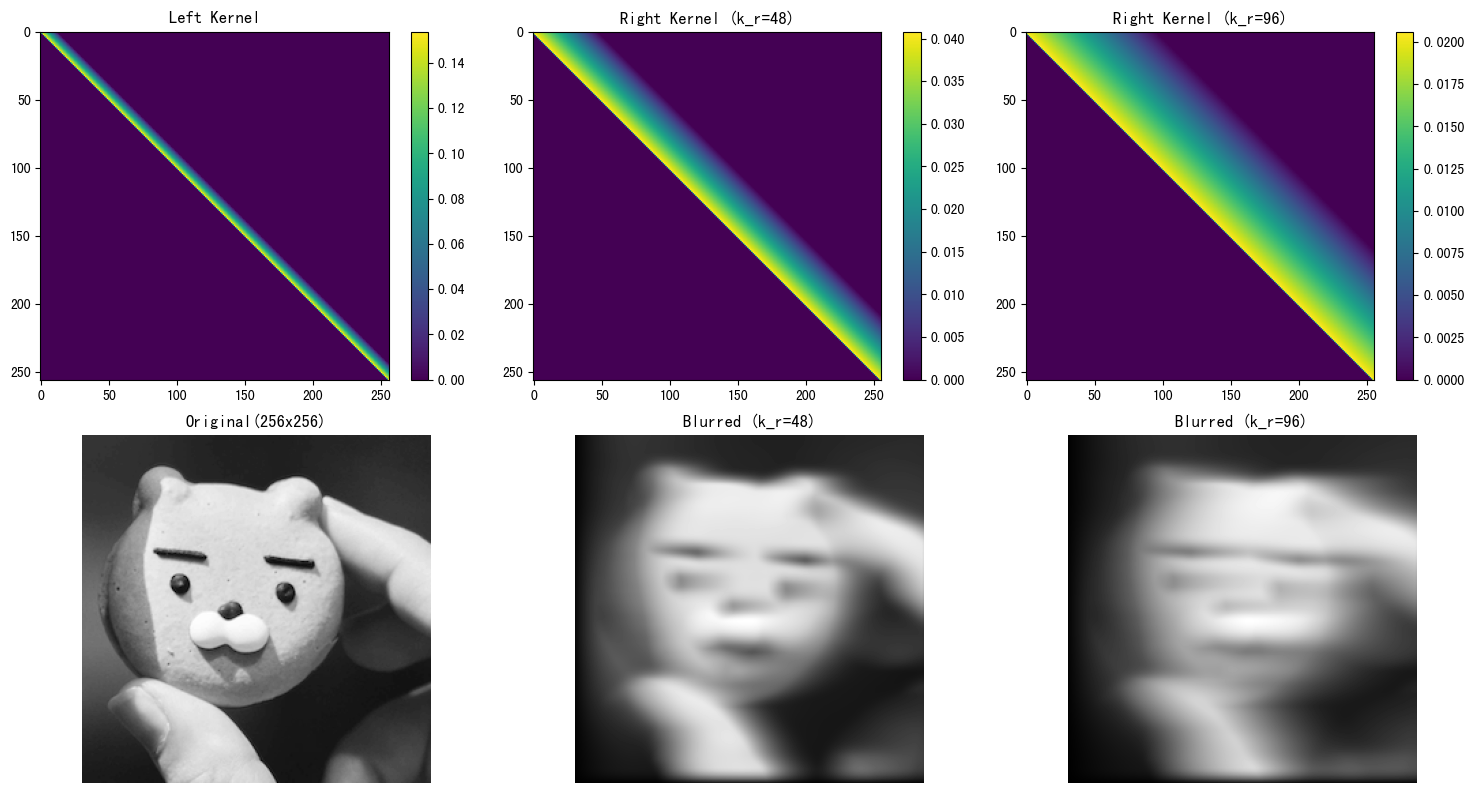

Saved all results for 256

Processing test_images/640_lion_original.png
Processing image of size 640x640


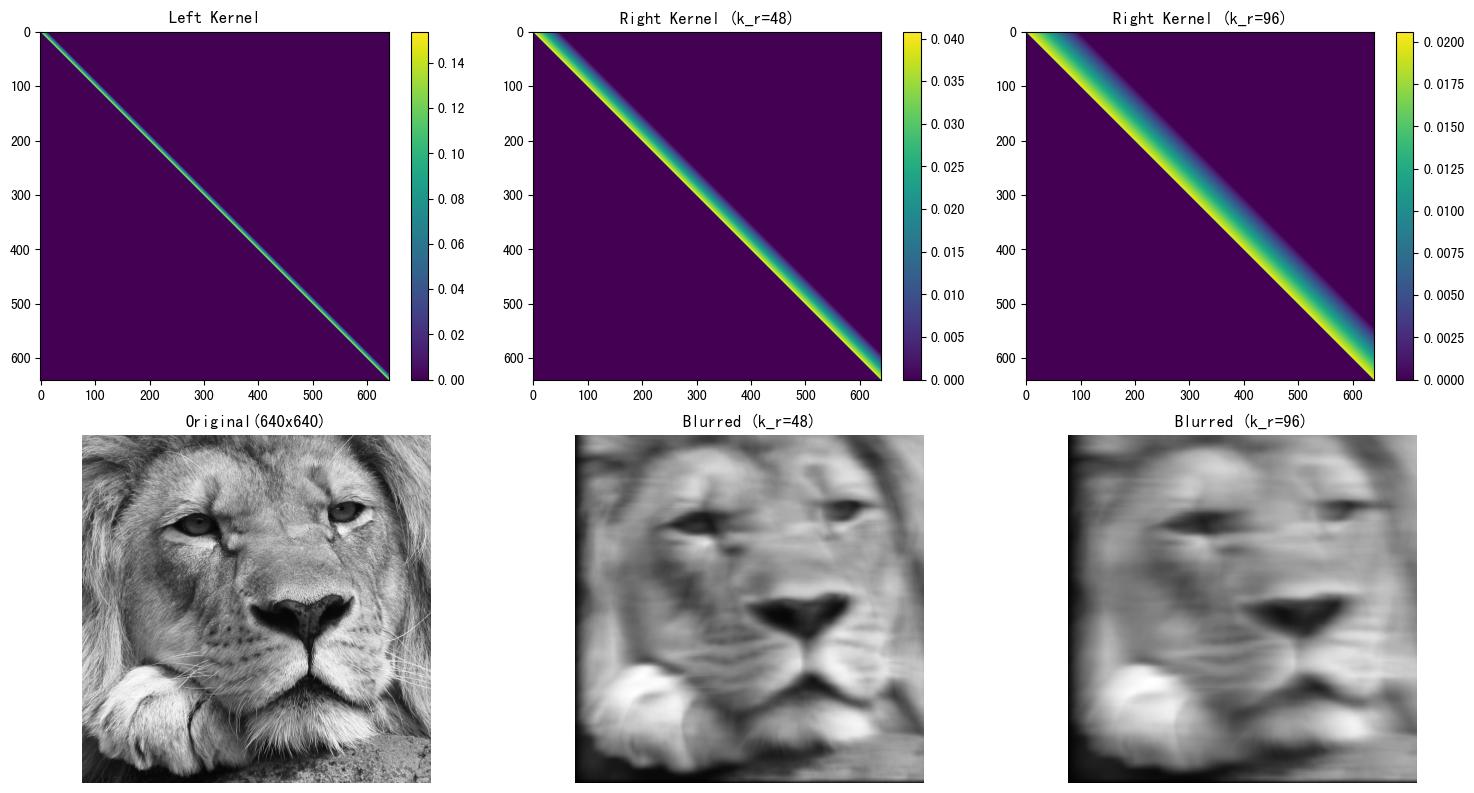

Saved all results for 640

Processing test_images/1024_books_original.png
Processing image of size 1024x1024


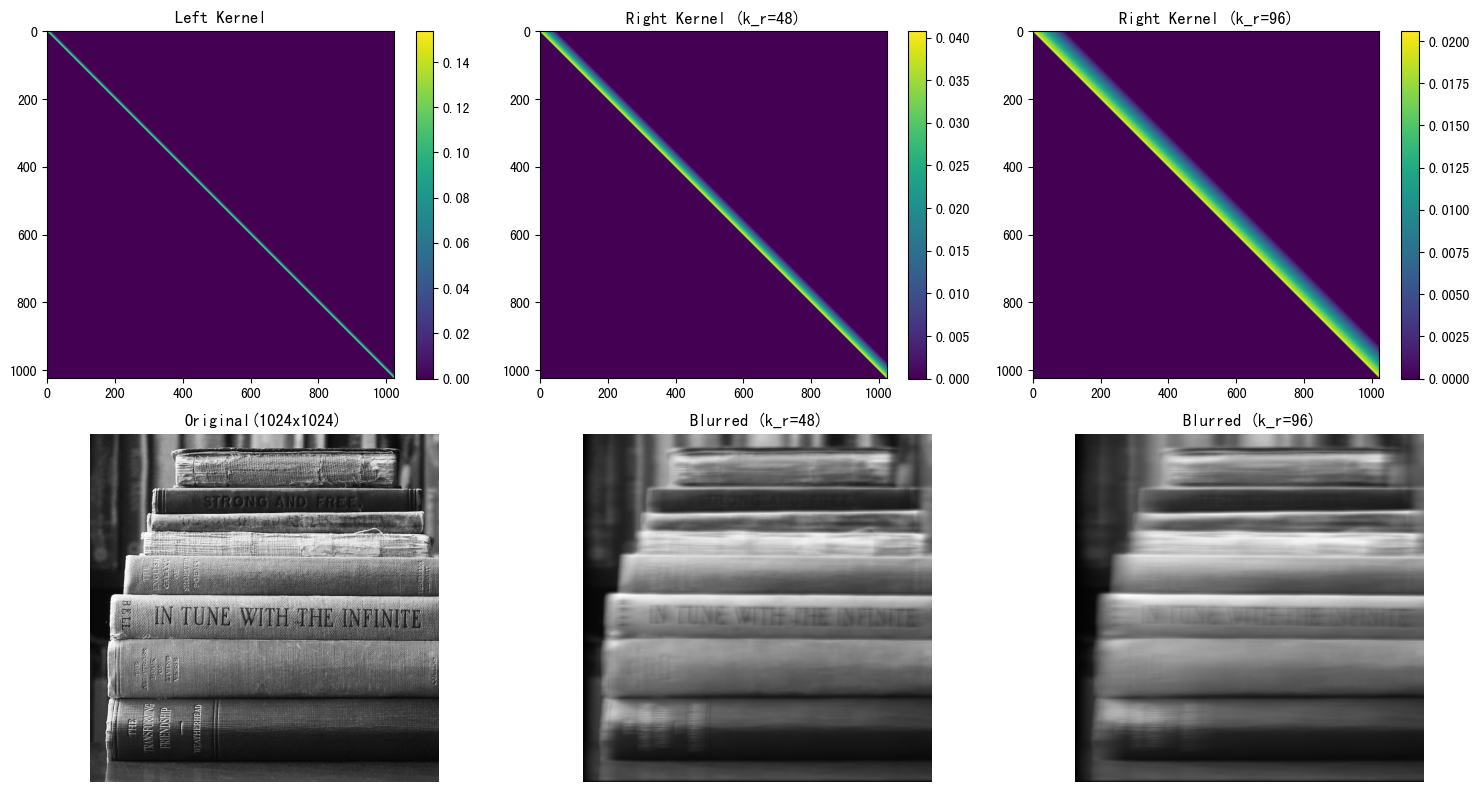

Saved all results for 1024

Processing test_images/1250_m1_original.png
Processing image of size 1250x1250


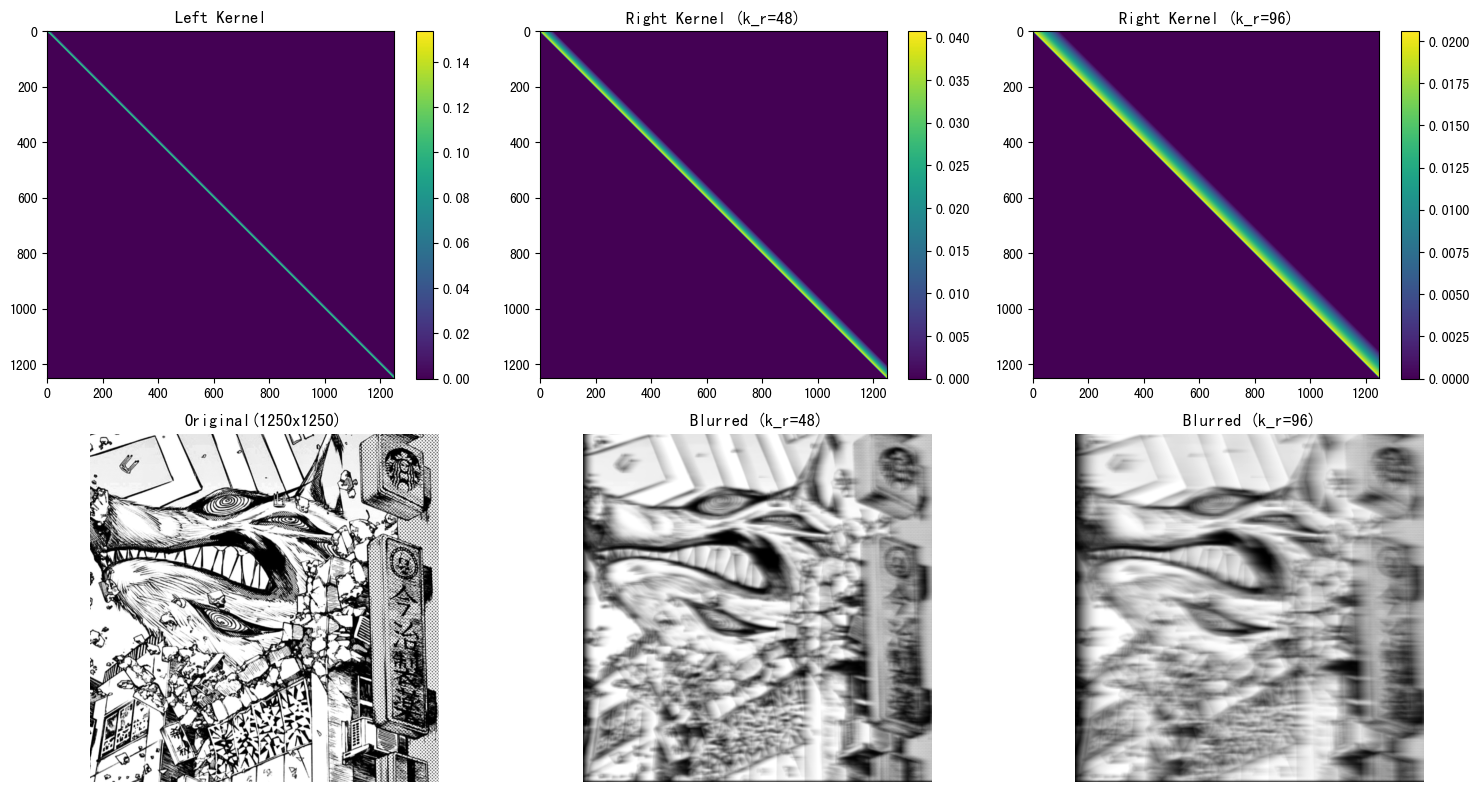

Saved all results for 1250

Processing test_images/3500_garlic_original.png
Processing image of size 3500x3500


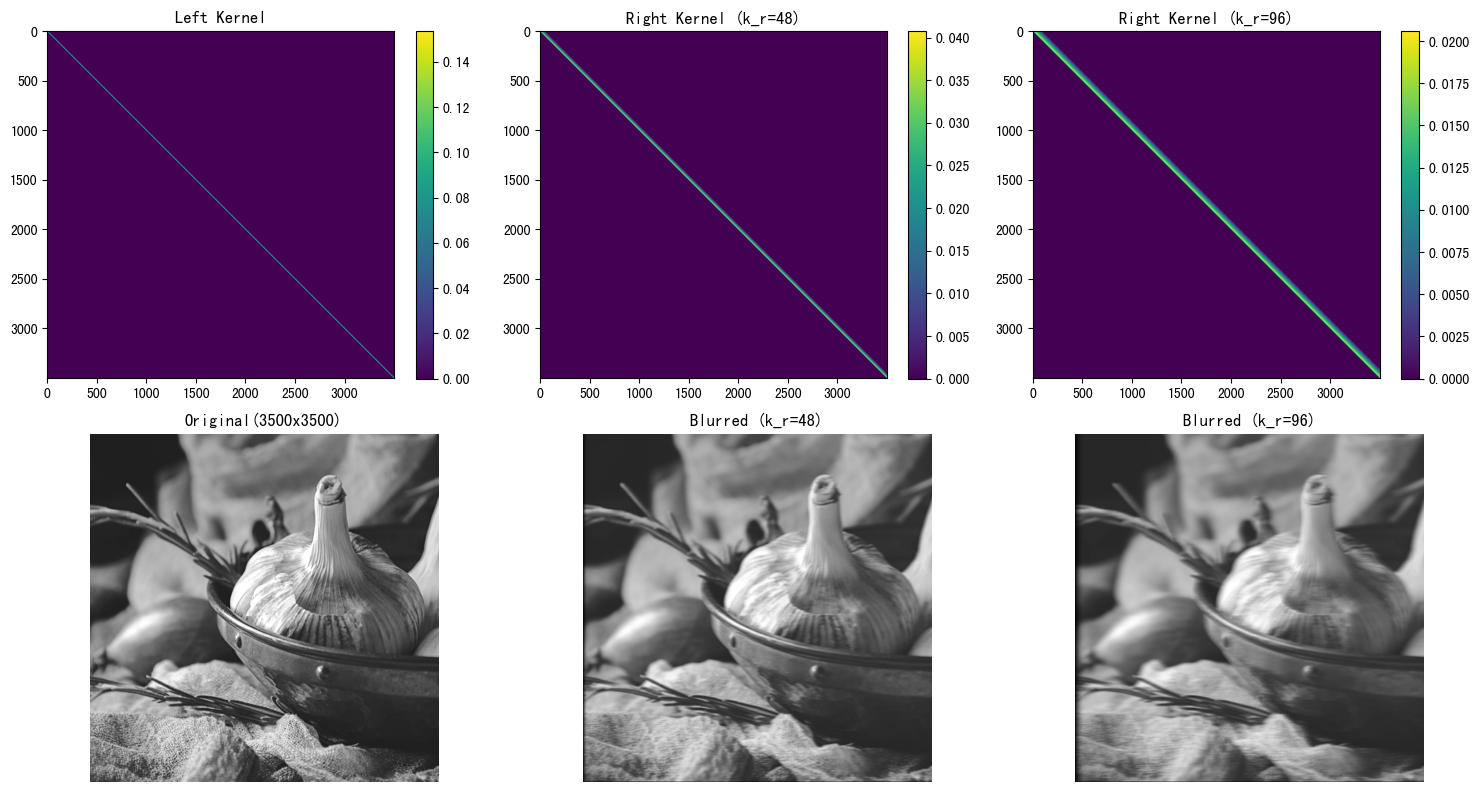

Saved all results for 3500
=====================Results with padding========================

Processing test_images/256_hand_original.png
Processing image of size 256x256


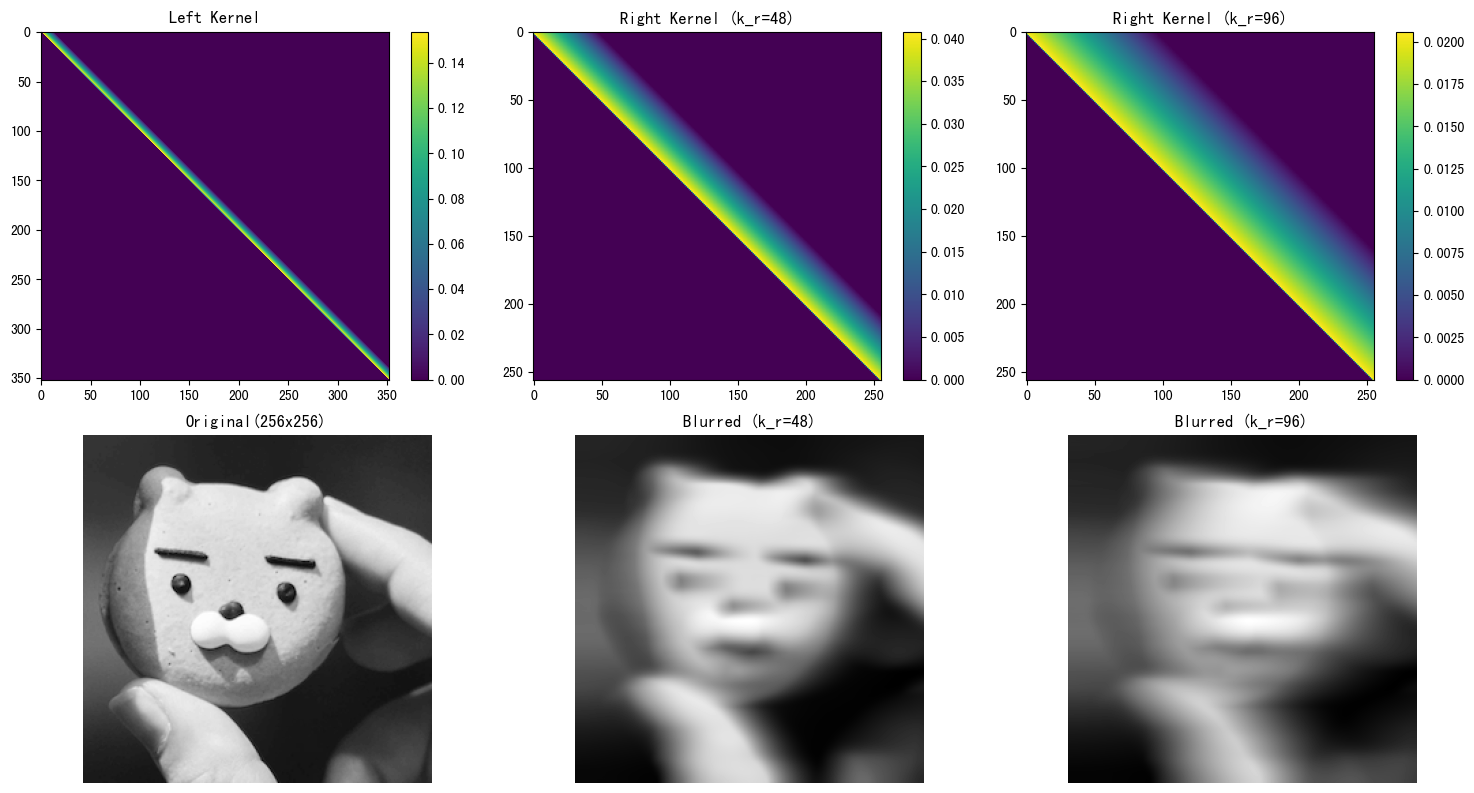

Saved all results for 256

Processing test_images/640_lion_original.png
Processing image of size 640x640


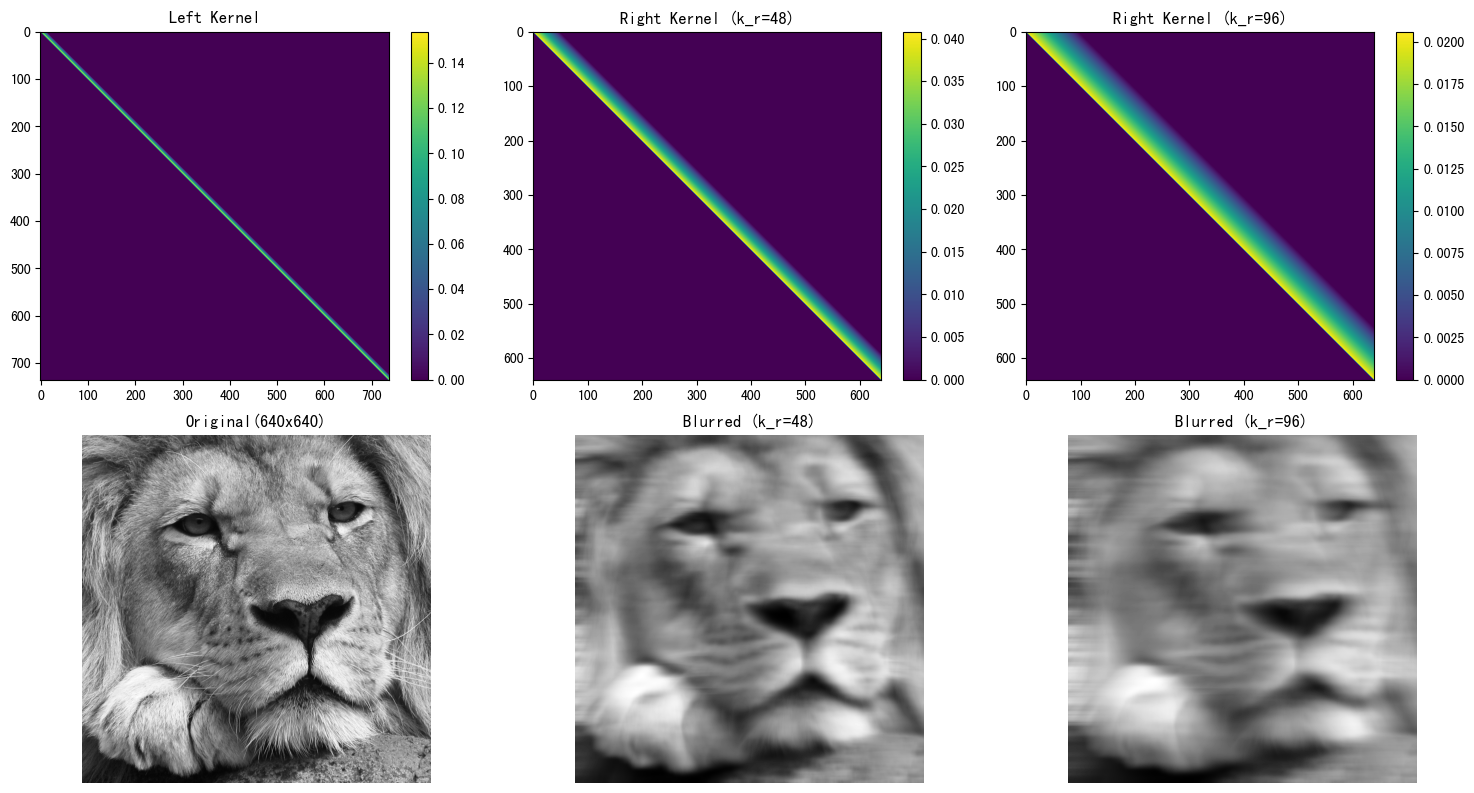

Saved all results for 640

Processing test_images/1024_books_original.png
Processing image of size 1024x1024


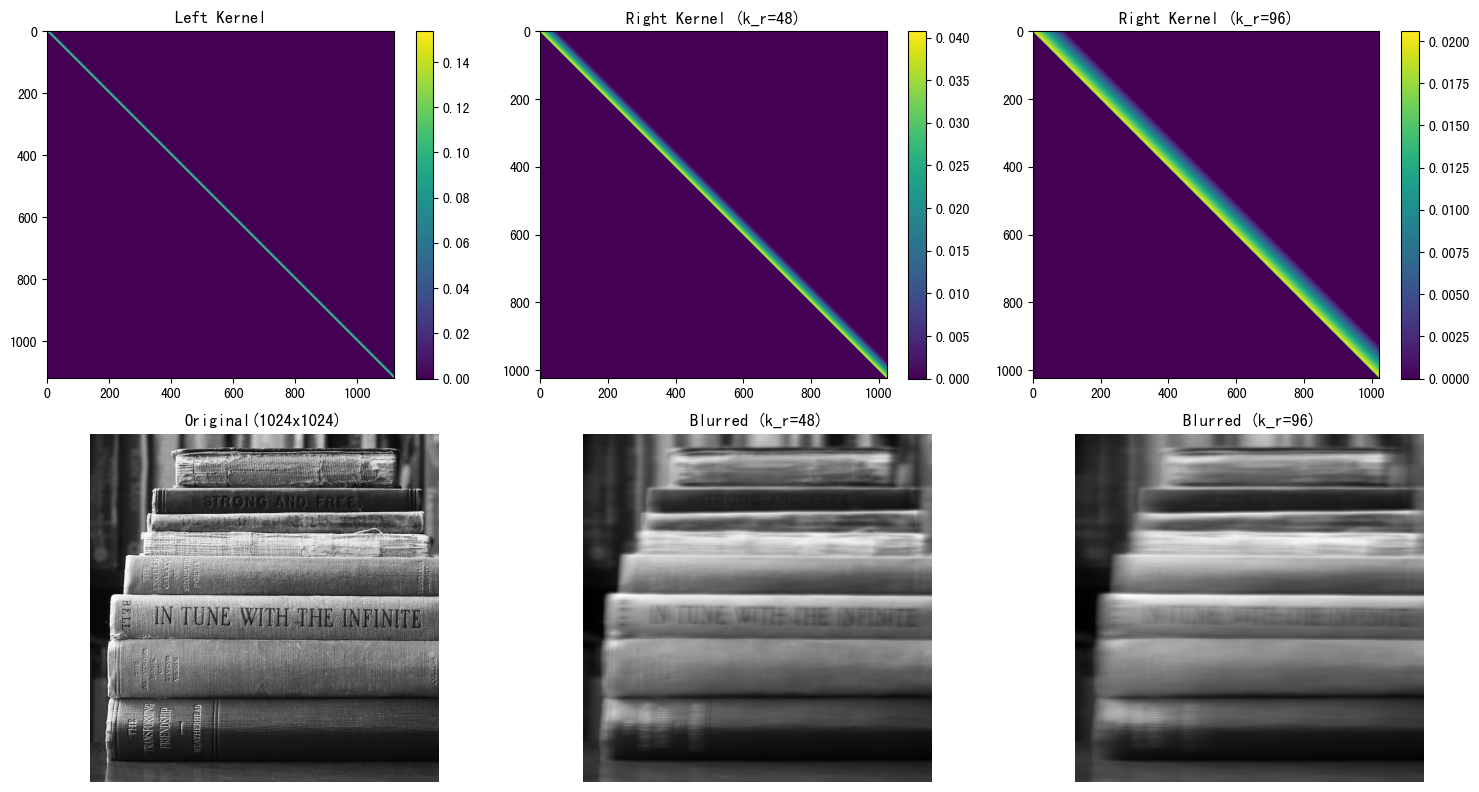

Saved all results for 1024

Processing test_images/1250_m1_original.png
Processing image of size 1250x1250


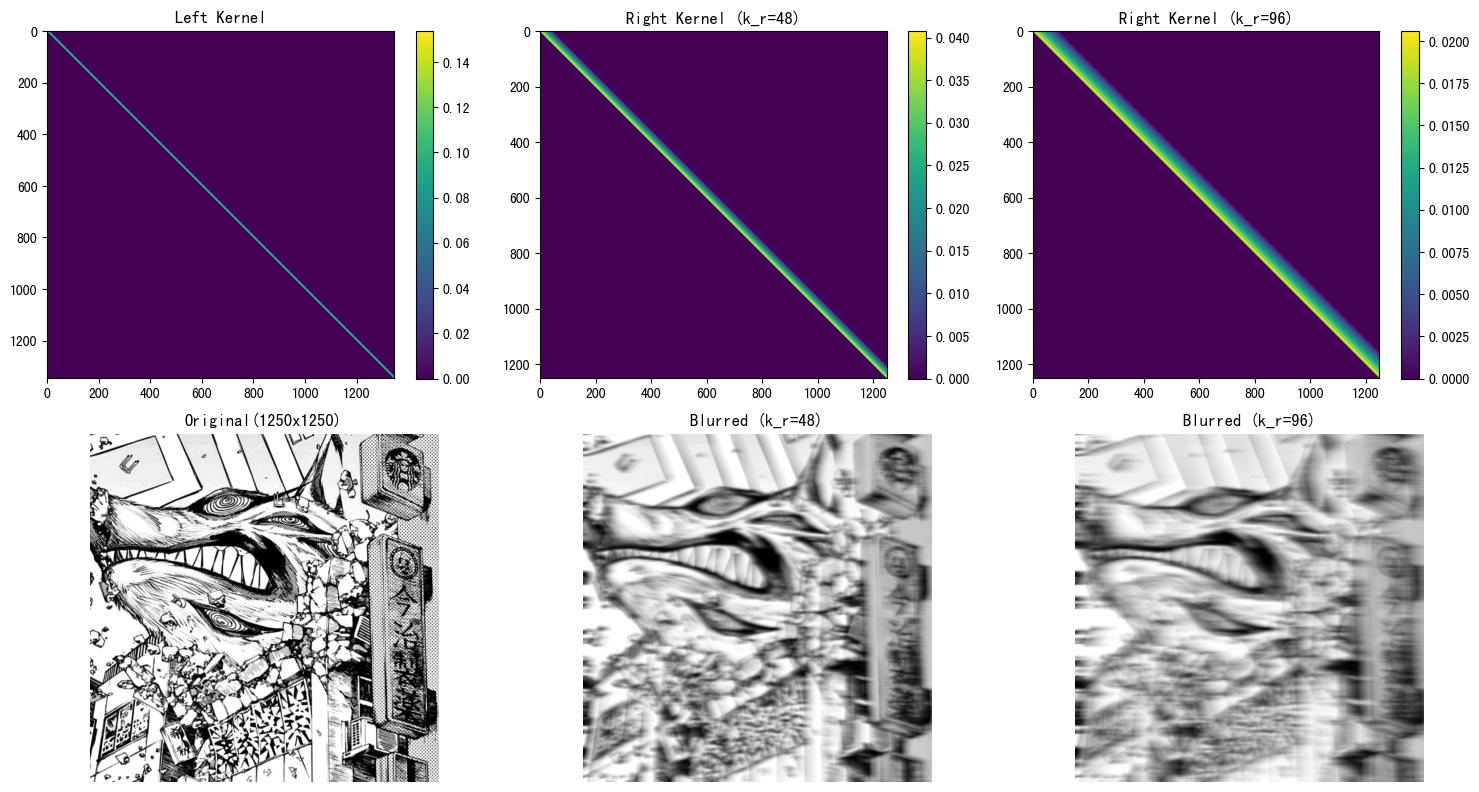

Saved all results for 1250

Processing test_images/3500_garlic_original.png
Processing image of size 3500x3500


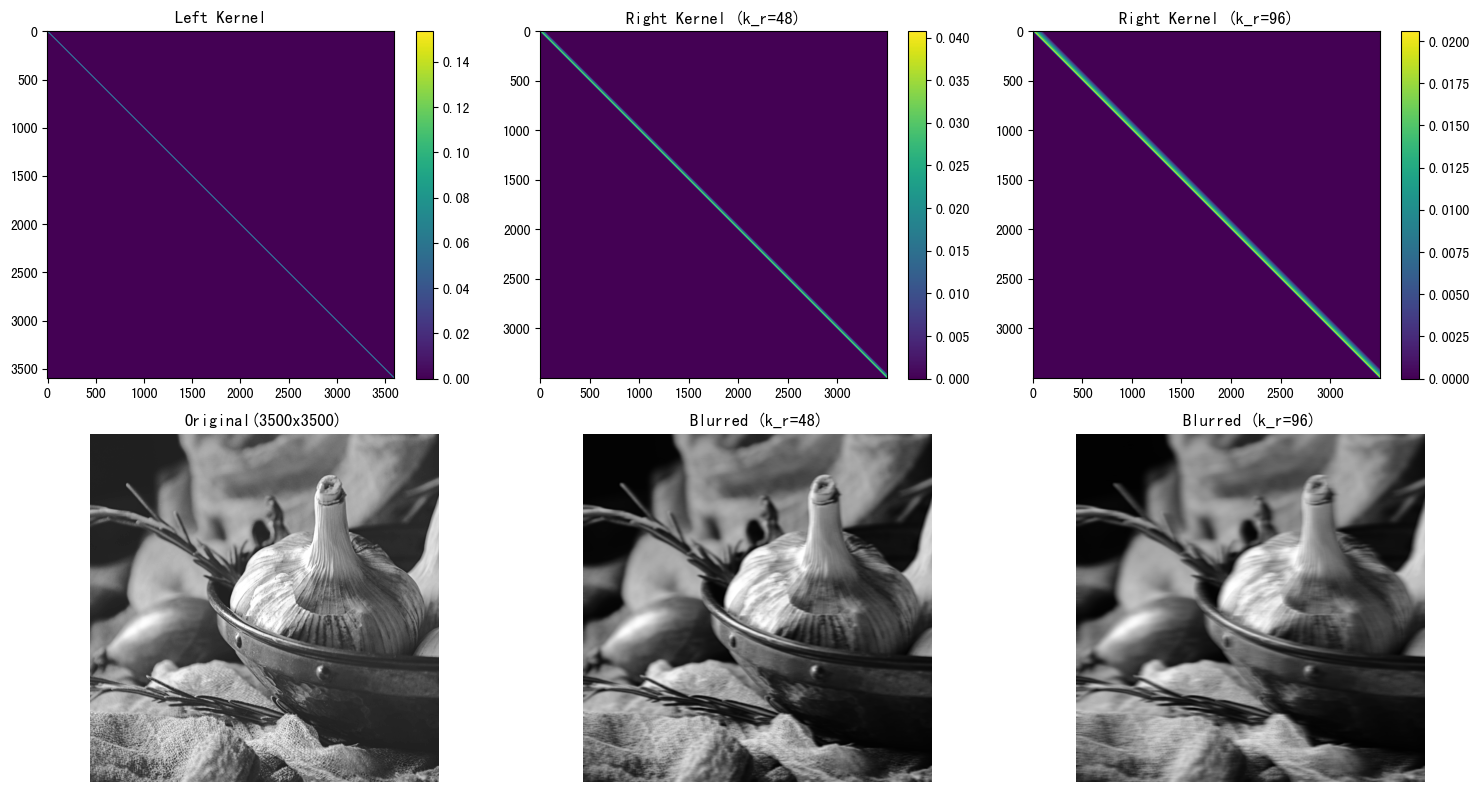

Saved all results for 3500


In [ ]:
def test_blurring(image_paths, k_r_values, pad=False):
    """Process all test images with different blur parameters"""
    os.makedirs('output2', exist_ok=True)

    for path in image_paths:
        print(f"\nProcessing {path}")
        process_all_kernels(path, k_r_values, pad)

def test_blurring_pad(image_paths, k_r_values, pad=True):
    """Process all test images with different blur parameters"""
    os.makedirs('output4', exist_ok=True)

    for path in image_paths:
        print(f"\nProcessing {path}")
        process_all_kernels(path, k_r_values, pad)


    # Test parameters and run
image_paths = [
    'test_images/256_hand_original.png',
    'test_images/640_lion_original.png',
    'test_images/1024_books_original.png',
    'test_images/1250_m1_original.png',
    'test_images/3500_garlic_original.png'
]
k_r_values = [48, 96]

test_blurring(image_paths, k_r_values, pad=False)
print("=====================Results with padding========================")
test_blurring(image_paths, k_r_values, pad=True)